# Convolutional Neural Networks

In [1]:
# importing important libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random
import tensorflow as tf
from sklearn.manifold import TSNE
# load images from cifar 10 data set
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

**Utility function for getting kernels(weights) and padding an image**

In [2]:
# function which pads up to the image
def padUp(image,value):
    temp  = image[1:value+1]
    temp = np.array(list(reversed(temp)))
    image = np.insert(image,0,temp,0)
    return image

# function which pads down to the image
def padDown(image,value):
    temp = image[-value-1:-1]
    temp = list(reversed(temp))
    image = np.insert(image,len(image),temp,0)
    return image

# get column(for 2d a column, for 3d a 2d matrix, ..)
def getcolumn(matrix, i):
    return [row[i] for row in matrix]

# function which pads left to the image
def padLeft(image,value):
    cols = []
    for i in range(1,value+1):
        cols.append(getcolumn(image,i))
    cols = np.array(list(reversed(cols)))
    cols = np.transpose((cols),(1,0,2))
    image = np.hstack((cols,image))
    return image

# function which pads right to the imagfe
def padRight(image,value):
    cols = []
    for i in range(image.shape[1]-value-1,image.shape[1]-1):
        cols.append(getcolumn(image,i))
    cols = np.array(list(reversed(cols)))
    cols = np.transpose((cols),(1,0,2))
    image = np.hstack((image,cols))
    return image

# function which gives the kernel
def getSharpeningKernel(k,c):
    kernel = np.ones((k,k,c))
    kernel *= -1
    for i in range(k):
        kernel[1][1][i] = 9
    # kernel[1][1][1] = 9
    return kernel

def getRandomKernel(l,b):
    kernel = np.ones((l,b))
    for x in range(l):
        for y in range(b):
                kernel[x][y] = -1+random.random()*2
    return kernel

**Non-Linear functions**

In [3]:
# non linear functions
# sigmoid
def sigmoid(x):
    exp = np.exp(x)
    return exp/(1+exp)
# tanh
def tanh(x):
    exp = np.exp(x)
    return (exp-(1/exp))/(exp+(1/exp))
# relu
def ReLu(x):
    return x * (x > 0)
# prelu
def pReLu(x,p):
    return x if x >= 0 else float(p)*float(x)

## 1. Convolution function

In [4]:
# function which pads u-d-l-r to image
def padImage(image,value):
    image = padUp(image,value)
    image = padDown(image,value)
    image = padLeft(image,value)
    image = padRight(image,value)
    return image

# function which flips kernel front to back, will be useful for convolution
def rotateKernel(kernel):
    kernel_copy = kernel.copy()
    m,n,h = kernel_copy.shape
    for i in range(m):
        for j in range(n):
            for k in range(h):
                kernel[i][j][k] = kernel_copy[m-1-i][n-j-1][h-1-k]
    return kernel

# convolution function
def convolute(image,kernel,stride,padding,nlf,channels,show=False):
    if show:
        print('-- Input Image --')
        plt.imshow(image)
        plt.show()
    image_cp = image.copy()
    # pad if padding is specified
    if padding:
        kernel_size = len(kernel)
        padding_value = (kernel_size-1)//2
        image = padImage(image,padding_value)

    l,b,h = image_cp.shape
    if not padding:
        l -= 2
        b -= 2
    convoluted = np.zeros((l//stride,b//stride))
    k = len(kernel)
    kernel = rotateKernel(kernel)

    # convolution
    for i in range(0,len(image_cp),stride):
        for j in range(0,len(image_cp[0]),stride):
            if i+k <= len(image) and j+k <= len(image[0]):
                temp_matrix = np.array(image[i:i+k,j:j+k,:])
                convoluted[i//stride][j//stride] = np.sum(np.multiply(temp_matrix,kernel[:,:,:]))

    # normalization
    max = np.max(convoluted)
    if max:
        convoluted /= max
    # print('Max - ',max)


    if show:
        print('Convoluted - ')
        plt.imshow(convoluted)
        plt.show()

    # applying non-linear functions to the result
    if nlf == 'sigmoid':
        convoluted = sigmoid(convoluted.astype('float128'))
        convoluted = convoluted.astype('float64')
        if show:
            print('Sigmoid')
            plt.imshow(convoluted)
            plt.show()
    elif nlf == 'tanh':
        convoluted = tanh(convoluted)
        if show:
            print('tanh')
            plt.imshow(convoluted)
            plt.show()
    elif nlf == 'relu':
        convoluted = ReLu(convoluted)
        if show:
            print('ReLu')
            plt.imshow(convoluted)
            plt.show()
    elif 'prelu' in nlf:
        p = nlf.split(':')[-1]
        preluler = lambda x: pReLu(x,int(p))      
        pfunc = np.vectorize(preluler)
        convoluted = pfunc(convoluted)
        if show:
            print('pReLu')
            plt.imshow(convoluted)
            plt.show()
    return convoluted

**Testing the above convolution with random cifar-10 image**

Image number :  42019
Kernel shape :  (3, 3, 3)
Kernel -- 
[[[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [ 9.  9.  9.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]]
-- Input Image --


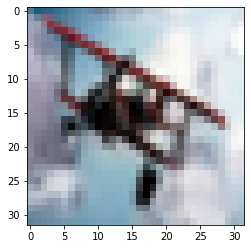

Convoluted - 


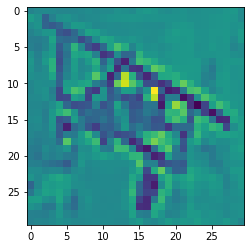

Sigmoid


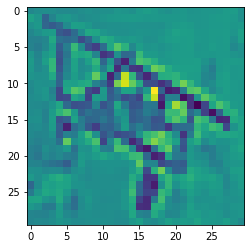

In [5]:
# image = plt.imread('/content/drive/MyDrive/deeplearning/assignment3/4.1.06-tree.tiff')
# image = plt.imread('/content/drive/MyDrive/deeplearning/assignment3/bird10.png')

# image = x_train[0]
image_num = random.randint(0,50000)
print('Image number : ',image_num)
image = x_train[image_num]
channels = np.array(image).shape[2]
stride = 1
padding = False
kernel = getSharpeningKernel(3,channels)
print('Kernel shape : ',kernel.shape)
print('Kernel -- ')
print(kernel)
convoluted_activated_image = convolute(image,kernel,stride,padding,'sigmoid',channels,True)

## 2. Pooling function

In [6]:
# pooling function
def pooling2d(image,stride,window_size,pool_option):
    image = np.array(image)
    l,b = image.shape
    wl,wb = window_size
    pooled_image = np.zeros((l//stride,b//stride))
    for i in range(0,l,stride):
        for j in range(0,b,stride):
            if pool_option == 'maxpool':
                pooled_image[i//stride][j//stride] = np.max(image[i:i+wl,j:j+wb])
            elif pool_option == 'minpool':
                pooled_image[i//stride][j//stride] = np.min(image[i:i+wl,j:j+wb])
            elif pool_option == 'avgpool':
                pooled_image[i//stride][j//stride] = np.mean(image[i:i+wl,j:j+wb])
    # pooled_image /= np.max(pooled_image)
    return pooled_image

**Testing pooling function with the above image**

Max pooling


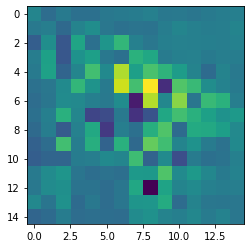

Average pooling


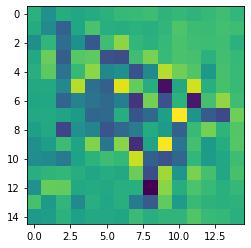

Min pooling


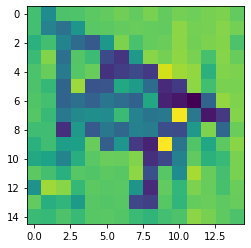

In [7]:
stride = 2
window_size = (2,2)
pooled_image_max = pooling2d(convoluted_activated_image,stride,window_size,'maxpool')
print('Max pooling')
# print(pooled_image)
plt.imshow(pooled_image_max)
plt.show()
pooled_image_avg = pooling2d(convoluted_activated_image,stride,window_size,'avgpool')
print('Average pooling')
plt.imshow(pooled_image_avg)
plt.show()
pooled_image_min = pooling2d(convoluted_activated_image,stride,window_size,'minpool')
print('Min pooling')
plt.imshow(pooled_image_min)
plt.show()

## 3. Convolution layer function

In [8]:
# convolution layer function
def convolute_nd(image,kernels,stride,padding,nlf,channels):
    convoluted_image = []
    # convoluting the image layer wise
    for kernel in kernels:
        convoluted_image.append(convolute(image,kernel,stride,padding,nlf,channels,False))
    convoluted_image = np.array(convoluted_image)
    # rotating the axes
    convoluted_image = convoluted_image.transpose(1,0,2)
    convoluted_image = convoluted_image.transpose(0,2,1)
    return np.array(convoluted_image)

def getRandomKernels(size,channels):
    kernels = []
    for i in range(size):
        kernel = np.zeros((3,3,channels))
        for i in range(3):
            for j in range(3):
                for channel in range(channels):
                    kernel[i][j][channel] = -1+random.random()*2
        kernels.append(kernel)
    return kernels

stride = 1
len_kernels = 5
kernels = getRandomKernels(len_kernels,channels)
for i in range(len_kernels):
    print(f'kernel {i}')
    print(kernels[i])
convoluted_nd_image = convolute_nd(image,kernels,stride,padding,'sigmoid',channels)
print('Convoluted nd shape : ',convoluted_nd_image.shape)

kernel 0
[[[-0.76843958  0.24605629  0.67828626]
  [-0.5821396   0.84026041  0.54778231]
  [-0.1936485   0.23576955  0.03835469]]

 [[-0.52444811 -0.20831132 -0.32842887]
  [-0.70902291 -0.46842142  0.37045934]
  [-0.37616506  0.14791033  0.84180183]]

 [[-0.52615312  0.23966264 -0.70578172]
  [ 0.53184189 -0.59823255 -0.21375765]
  [-0.61656007 -0.3278028   0.25079947]]]
kernel 1
[[[ 0.48595895 -0.46326394 -0.82619559]
  [-0.67040493 -0.70758664  0.28548002]
  [-0.73039154  0.61064817 -0.52978085]]

 [[ 0.1470966   0.01763372 -0.45634142]
  [-0.25990866 -0.48816763 -0.74794809]
  [ 0.10875064  0.08032521 -0.31158155]]

 [[ 0.24450465 -0.87851988 -0.51857674]
  [ 0.51097373  0.087118    0.07850439]
  [-0.64395964  0.48301562 -0.18067612]]]
kernel 2
[[[-0.95882971 -0.53072592 -0.67150179]
  [ 0.8995304   0.39225329  0.64066055]
  [ 0.52388026  0.33949189  0.0022206 ]]

 [[-0.13103511 -0.3883478   0.59244234]
  [-0.01732894  0.88727364 -0.53014936]
  [-0.66596402 -0.43679345 -0.03955336]

## 4. Pooling Layer function

In [9]:
# pooling layer function
def poolingnd(image,stride,window_size,pool_option):
    image = np.array(image)
    l,b,h = image.shape
    wl,wb = window_size
    channels = h
    pooled_image = np.zeros((l//stride,b//stride,h))
    for i in range(0,l,stride):
        for j in range(0,b,stride):
            for channel in range(channels):
                if pool_option == 'maxpool' and (i+wl < image.shape[0] and j+wb < image.shape[1]):
                    pooled_image[i//stride][j//stride][channel] = np.max(image[i:i+wl,j:j+wb,channel:channel+1])
                elif pool_option == 'minpool' and (i+wl < image.shape[0] and j+wb < image.shape[1]):
                    pooled_image[i//stride][j//stride][channel] = np.min(image[i:i+wl,j:j+wb,channel:channel+1])
                elif pool_option == 'avgpool' and (i+wl < image.shape[0] and j+wb < image.shape[1]):
                    pooled_image[i//stride][j//stride][channel] = np.mean(image[i:i+wl,j:j+wb,channel:channel+1])

    return pooled_image

# testing
stride = 2
poolednd_image_max = poolingnd(convoluted_nd_image,stride,window_size,'maxpool')
# print('-- Random colours is the result of random kernel range[-1,1]')
# print('-- Maxpool --')
# plt.imshow(poolednd_image_max)
plt.show()
poolednd_image_avg = poolingnd(convoluted_nd_image,stride,window_size,'avgpool')
# print('-- Average pool --')
# plt.imshow(poolednd_image_avg)
# plt.show()
poolednd_image_min = poolingnd(convoluted_nd_image,stride,window_size,'minpool')
# print('-- Minpool --')
# plt.imshow(poolednd_image_min)
# plt.show()
# print('-- Random colours is the result of random kernel range[-1,1]')

# working fine, if len kernels != 3, it can't be displayed as an image

## 5. Flattening (unraveling) function:

In [10]:
# flatten 2d
def flatten2d(pooled_image):
    l,b = pooled_image.shape
    flattened_list = []
    for i in range(l):
        for j in range(b):
                flattened_list.append(pooled_image[i][j])
    return flattened_list

pooled_image = pooling2d(convoluted_activated_image,stride,window_size,'maxpool')
flattened_list_2d = flatten2d(pooled_image)

# flatten nd
def flattennd(pooled_image,size):
    image_flat = pooled_image.flatten()
    weight_matrix = np.zeros((size,len(image_flat)))
    for i in range(len(weight_matrix)):
        for j in range(len(weight_matrix[0])):
            weight_matrix[i][j] = -1+random.random()*2
    return np.matmul(weight_matrix,image_flat)
    # return pooled_image.reshape(size)

## 6. Multi layer perceptron(MLP) fully connected 

In [11]:
# softmax function
def softmax_func(vector):
    num = np.exp(vector)
    den = np.sum(np.array([np.exp(x) for x in vector]))
    return num/den

# mlp
def mlp(vector,no_hidden_layers,size_of_hidden_layer,nlf,size_of_output_layer,softmax):
    output = vector

    for i in range(no_hidden_layers):
        kernel = getRandomKernel(size_of_hidden_layer[i],len(output))
        output = np.matmul(kernel[:,:],output)
        if nlf == 'sigmoid':
            output = sigmoid(output.astype('float128'))

    random_kernel = getRandomKernel(size_of_output_layer,size_of_hidden_layer[-1])
    res = np.matmul(random_kernel,output)

    # applying softmax
    if softmax:
        res = softmax_func(res.astype('float128'))
    return res

# testing attributes
hidden_layers = 1
pooled_image = poolednd_image_max
flatten_size = 25
flattened_list = flattennd(poolednd_image_max,flatten_size)
size_of_hidden_layer = 25
nlf = 'sigmoid'
size_of_output_layer = 10
softmax = True

size_of_hidden_layer = []
for i in range(hidden_layers):
    size_of_hidden_layer.append(random.randint(50,100))

res = mlp(flattened_list,hidden_layers,size_of_hidden_layer,nlf,size_of_output_layer,softmax)
print('Test result : ',res)

Test result :  [5.04206461e-04 2.94218996e-01 1.33263611e-03 1.78172867e-04
 6.59378144e-04 1.24110897e-03 1.80013532e-01 3.17309217e-04
 2.60415558e-05 5.21508619e-01]


**Utility functions for getting kernels(weights)**

In [12]:
def getRandomKernel3d(l,b,h):
    kernel = np.zeros((l,b,h))
    for i in range(l):
        for j in range(b):
            for k in range(h):
                kernel[i][j][k] = -1+random.random()*2
    return kernel

def getKernels(size,l,b,h):
    kernels = []
    for i in range(size):
        kernels.append(getRandomKernel3d(l,b,h))
    return kernels    

## 7. Feed-Forward path

In [13]:
# ffp
def feed_forward_path(image):
    # values given exactly in question 7
    no_kernels_first = 16
    l,b,h = 3,3,3
    kernels_first_layer = getKernels(no_kernels_first,l,b,h)

    no_kernels_second = 8

    nlf = 'sigmoid'
    stride_convolution = 1
    stride_pooling = 2
    window_size = (2,2)
    padding = False
    channels = image.shape[2]
    pool_option = 'maxpool'

    no_hidden_layers = 1
    size_of_output_layer = 10
    size_of_hidden_layer = []
    for i in range(no_hidden_layers):
        size_of_hidden_layer.append(random.randint(50,100))

    convolution1 = convolute_nd(image,kernels_first_layer,stride_convolution,padding,nlf,channels)
    max_pooling1 = poolingnd(convolution1,stride_pooling,window_size,pool_option)

    kernels_second_layer = np.array(getKernels(no_kernels_second,l,b,max_pooling1.shape[2]))
    convolution2 = convolute_nd(max_pooling1,kernels_second_layer,stride_convolution,padding,nlf,channels)
    max_pooling2 = poolingnd(convolution2,stride_pooling,window_size,pool_option)

    flattened_list_size = 25
    flattened_list = flattennd(max_pooling2,flattened_list_size)

    result = mlp(flattened_list,no_hidden_layers,size_of_hidden_layer,nlf,size_of_output_layer,softmax)
    return result,flattened_list


image = x_train[image_num]

# result_vector,flattened_list = feed_forward_path(image,kernels_first_layer,no_kernels_second,stride,padding,nlf,channels,window_size,pool_option,l,b,no_hidden_layers,size_of_hidden_layer,size_of_output_layer,softmax)
result_vector,flattened_list = feed_forward_path(image)
print(f'resultant vector : {result_vector}')

resultant vector : [7.17116293e-02 3.88915822e-03 2.18488590e-04 3.46576656e-04
 7.94613918e-03 1.85534098e-03 8.06467951e-01 3.52205245e-02
 8.21502716e-05 7.22620418e-02]


## 8. Testing 

label :  0


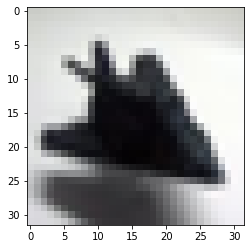

resultant vector :  [1.74651308e-02 5.52103853e-05 2.63324303e-01 8.88619543e-03
 2.07465755e-01 3.42657664e-04 1.44828177e-05 1.75729598e-01
 1.64077621e-01 1.62639046e-01]
label :  1


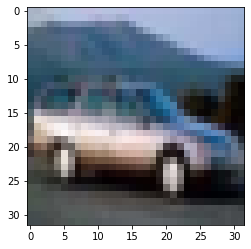

resultant vector :  [2.81125092e-04 5.21408666e-06 1.74553032e-03 1.16473348e-02
 9.44152108e-03 6.77054225e-04 2.73183955e-03 6.93321364e-04
 6.06047503e-01 3.66729556e-01]
label :  2


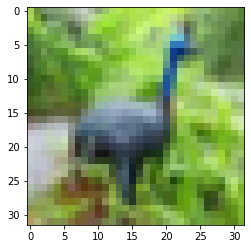

resultant vector :  [1.67314432e-07 3.44666075e-03 1.16149836e-04 2.61740293e-04
 9.95388084e-01 3.35210629e-05 7.20203831e-04 1.61483348e-06
 3.11096314e-05 7.48173391e-07]
label :  3


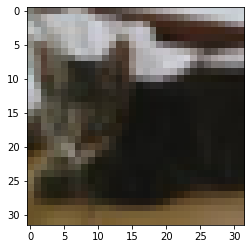

resultant vector :  [0.00097819 0.02357641 0.10925679 0.01378764 0.01523135 0.00128756
 0.06047367 0.0875028  0.00095631 0.68694928]
label :  4


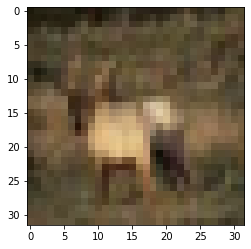

resultant vector :  [2.21046002e-04 3.61563840e-04 4.57621993e-06 2.95328436e-02
 6.95708765e-03 1.78705308e-03 4.61990503e-05 5.71165760e-04
 9.74817069e-07 9.60517490e-01]
label :  5


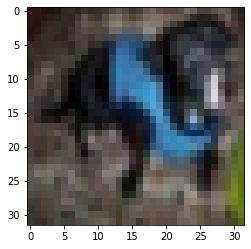

resultant vector :  [5.74469729e-02 3.07000828e-01 3.24404654e-06 1.15488093e-02
 1.08213278e-01 1.95746981e-05 1.26467806e-05 4.84727597e-01
 2.31526855e-02 7.87436449e-03]
label :  6


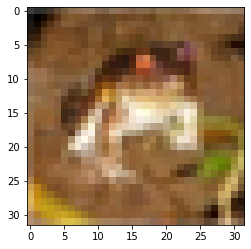

resultant vector :  [2.82641276e-05 2.67983981e-04 6.29902739e-04 6.82673239e-01
 2.28932371e-02 2.89673741e-01 6.26960457e-05 2.71576761e-03
 3.03888915e-04 7.51279503e-04]
label :  7


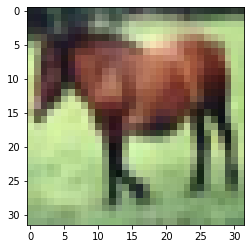

resultant vector :  [1.44324257e-03 4.45202270e-05 4.19368848e-05 1.85227506e-04
 1.02554342e-02 9.86503581e-01 7.36489308e-06 1.47672983e-03
 2.43073488e-06 3.95322733e-05]
label :  8


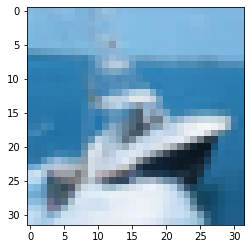

resultant vector :  [0.1243705  0.2024292  0.0615709  0.00109145 0.00310814 0.4354146
 0.13867572 0.01178559 0.01870166 0.00285223]
label :  9


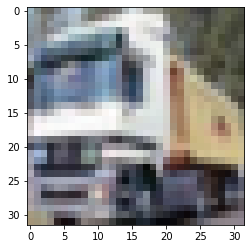

resultant vector :  [7.80546357e-05 8.07597227e-01 4.55235943e-03 7.73568290e-02
 9.69362470e-04 6.24721705e-04 1.85928569e-02 1.28264705e-04
 5.44642365e-02 3.56360878e-02]


In [14]:
# 8.a

# getting 10 images one from one label
images = {}
for i in range(y_train.shape[0]):
    if y_train[i][0] in images: continue
    else: images[y_train[i][0]] = x_train[i]
images = dict(sorted(images.items(), key=lambda item: item[0]))

# applying ffp on images with given values
for i in images.keys():
    print('label : ',i)
    plt.imshow(images[i])
    # print(images[i].shape)
    plt.show()
    result,flat_list = feed_forward_path(images[i])
    print('resultant vector : ',result)

As the values are too low, we are not able to observe any trends

In [15]:
images = {}
for i in range(len(x_train)):
    if y_train[i][0] in images:
        if len(images[y_train[i][0]]) < 3:
            images[y_train[i][0]].append(x_train[i])
    else:
        images[y_train[i][0]] = [x_train[i]]
images = dict(sorted(images.items(), key=lambda item: item[0]))

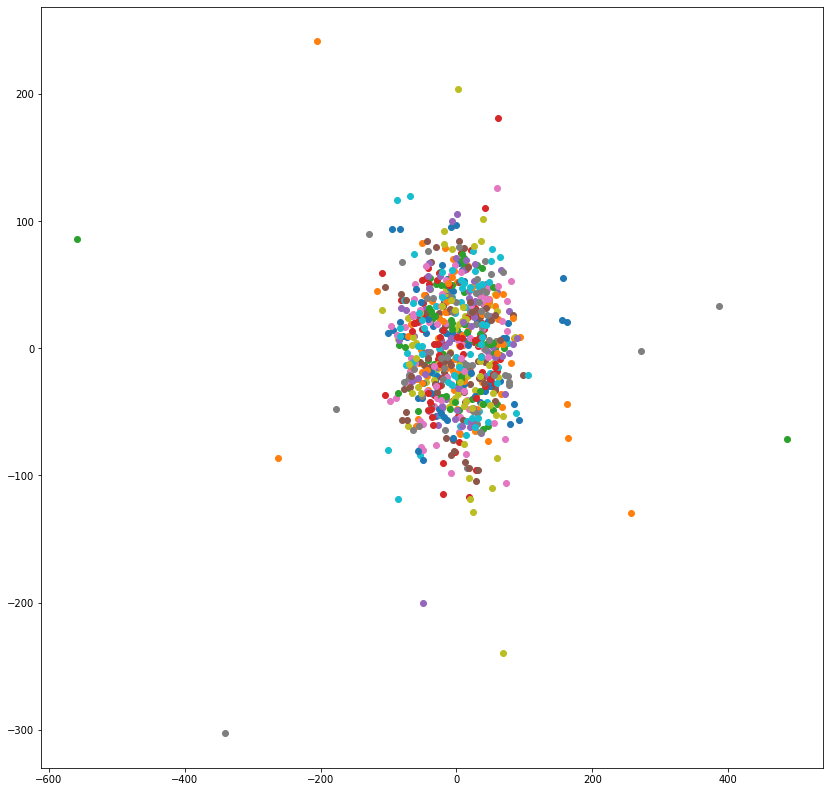

In [16]:
# plt.axis('square') 
plt.rcParams["figure.figsize"] = (14,14)
for i in images:
    for image in images[i]:
        result,flat_list = feed_forward_path(image)
        tsne_xy = TSNE(n_components=2,perplexity=2,n_iter=300,init='random',learning_rate='auto',random_state=0).fit_transform(flat_list.reshape(-1,1).astype('float128'))
        plt.scatter(tsne_xy[:,0],tsne_xy[:,1])

A randomly initialized network doesn't show much discriminability